# Creating a Neural Network with Numpy

I do not reccomend this, it's waaaay slower than keras for obvious reasons.<br>
But it's a fun way to learn the inner workings of basic neural networks

In [0]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,f1_score

In [0]:
# get data
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


# Functions

## Helpers to Summarize Tests

In [0]:
def printTrainPerformance(accList, costList):
  ''' plots the accuracy and cost lists on the same graph '''
    print("Training Performance:")
    print(f"Final iter ACC:{np.round(accList[-1],decimals=4)}")
    
    length = len(accList)
    xAxis = np.linspace(0 , length,num=length)
    fig, ax1 = plt.subplots()

    ax1.title.set_text('Training Performance')
    color = 'tab:red'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Error', color=color)
    ax1.plot(xAxis, costList, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color) 
    ax2.plot(xAxis, accList, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()
    
def printTestInfo(max_iter,alpha, hidden_layers, batch_size,lamb):
  ''' prints summary of model parameters'''
    print("********************")
    print(f"Iterations:{max_iter}")
    print(f"Learning Rate:{alpha}")
    print(f"Hidden Layer Sizes:{hidden_layers}")
    print(f"Training Batch Size: {batch_size}")
    print(f"Lambda:{lamb}")
    print("********************")

## Activation Functions 

In [0]:
def relu(z):
    return np.maximum(0,z)

def relu_prime(z):
    rPrime = np.where(z>=0,1,0) 
    return rPrime

def softmax(z):
    expz = np.exp(z-np.max(z))
    return expz / expz.sum(axis=1, keepdims=True)

## Training function

In [0]:
def train(X, Y, max_iter=1000, alpha=0.01, hidden_layers=[50,40,30], lamb = 0, batch_size=1000, verbose = False):
    
    #initialize constants
    HlActivation = relu
    hlDerive = relu_prime
    class_count = len(np.unique(y_train))
    data_set_size = len(Y)
    hl_count = len(hidden_layers)
    input_size = np.size(X[0])
    
    #make sure valid batch_size is used
    batch_size = min(batch_size,data_set_size)
    batch_size = max(batch_size,1)
    
    # print test summary and prep lists to store performance
    if verbose:
        costList = []
        accList = []
        printTestInfo(max_iter,alpha, hidden_layers, batch_size,lamb)
    
    # encode y to make vector operations easier
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit([[i] for i in range(0,class_count)])
    R = enc.transform([[yi] for yi in Y]).toarray()
    
    # flatten each instance into a vector
    X = np.reshape(X,(data_set_size,X[0].size))#does nothing if instances are already 1d
    X = np.where(X>0,1,0)# normalize data to be boolean
    
    # randomize weights for all hidden and output layers
    WH = []# initialize list to hold weight matrices for hidden layers
    BH = []# initialize list to hold bias weight matrices for hidden layers
    np.random.seed(10)
    input_dim = input_size
    for layer_size in hidden_layers:#hidden layers
        WH.append(np.random.randn(input_dim,layer_size)*0.1)
        BH.append(np.zeros((layer_size)))
        input_dim = layer_size
    WO = np.random.randn(input_dim,class_count)*0.1# initialize weights of output layer
    BO = np.zeros((class_count))# initialize bias weights of output layer
 
    for iter_ in range(max_iter):
        
        # shuffle data before each iteration
        X_shuffled,R_shuffled = shuffle(X,R)
        #grab batch size amount of data
        batch_X = X_shuffled[:batch_size]
        batch_R = R_shuffled[:batch_size]
        
        # initialize weight deltas
        delta_wo = None
        delta_bo = None
        delta_wh = []
        delta_bh = []      
        a = [batch_X]# initialize list to hold outputs for each layer
        z = []#initialize list to hold inputs for each layer

        # Forward prop through hidden layers
        for layer_weights, layer_bias in zip(WH, BH):
            z.append(np.dot(a[-1],layer_weights) + layer_bias)
            layer_output = HlActivation(z[-1])
            a.append(layer_output)

        # Forward prop though output layer
        z.append(np.dot(a[-1],WO) + BO)
        outputProbs = softmax(z[-1])
        
        # check ACC and Cost
        if verbose:
            correct = 0
            for i in range(batch_size):
                if np.argmax(outputProbs[i]) == np.argmax(batch_R[i]):
                    correct+=1
            accList.append(correct/batch_size)
            costList.append(-np.sum(np.log(outputProbs)*batch_R))
            # add L2 Norm to cost
            for i in range(hl_count):
                costList[-1] += np.sum(np.power(WH[i],2))
                costList[-1] += np.sum(np.power(BH[i],2))
            costList[-1] += np.sum(np.power(BO,2))
            costList[-1] += np.sum(np.power(WO,2))

        # Backprop output layer
        de_dzo = outputProbs - batch_R
        dzo_dwo = a[-1]
        delta_wo = np.dot(dzo_dwo.T, de_dzo)
        delta_bo = de_dzo.sum(axis=0)

        #store values for next layer backprop
        dzPrev_dah = WO
        de_dzPrev = de_dzo
      
        # Backprop with reverse loop through hidden layers
        for cur_weights, cur_z, prev_a in zip(WH[::-1],z[-2::-1],a[-2::-1]):
            de_daCur = np.dot(de_dzPrev, dzPrev_dah.T)
            daCur_dzCur = hlDerive(cur_z)
            dzCur_dwCur = prev_a
            
            #store changes to be made to weights
            delta_wh.insert(0,np.dot(dzCur_dwCur.T, daCur_dzCur*de_daCur))
            delta_bh.insert(0,(de_daCur*daCur_dzCur).sum(axis=0))
            
            #store values for next layer backprop
            de_dzPrev = daCur_dzCur*de_daCur
            dzPrev_dah = cur_weights
        
        # Update weights
        WO *= (1 - (alpha*lamb/batch_size))#weight decay
        BO *= (1 - (alpha*lamb/batch_size))
        WO = np.subtract(WO,alpha*delta_wo/batch_size)#apply deltas
        BO = np.subtract(BO,alpha*delta_bo/batch_size)
        for wi in range(hl_count):
            WH[wi] *= (1 - (alpha*lamb/batch_size))#weight decay
            BH[wi] *= (1 - (alpha*lamb/batch_size))
            WH[wi] = np.subtract(WH[wi],alpha*delta_wh[wi]/batch_size)#apply deltas
            BH[wi] = np.subtract(BH[wi],alpha*delta_bh[wi]/batch_size)
        
    if verbose:
        printTrainPerformance(accList, costList)

    return WH,BH,WO,BO

## Prediction Function

In [0]:
def predict(X,Y,trained_WH,trained_BH, trained_WO,trained_BO):
    WH = trained_WH
    BH = trained_BH
    WO = trained_WO
    BO = trained_BO
    HlActivation = relu
    data_set_size = len(Y)
    K = len(trained_WO[0])
    
    # flatten instance matrices into vectors
    X = np.reshape(X,(data_set_size,X[0].size))
    X = np.where(X>0,1,0)# normalize data to be boolean
    
    predictions = []
    correct = np.array([0 for i in range(K)])
    wrong = np.array([0 for i in range(K)])
    for instance, r in zip(X,Y):
        
        # Forward prop through hidden layers
        z = []
        a = [instance.reshape(1,instance.size)]
        for layer_weights, layer_bias in zip(WH, BH):
            z.append(np.dot(a[-1],layer_weights) + layer_bias)
            layer_output = HlActivation(z[-1])
            a.append(layer_output)

        # Forward prop though output layer
        z.append(np.dot(a[-1],WO) + BO)
        outputProbs = softmax(z[-1])
        
        predictions.append(np.argmax(outputProbs))
            
    return predictions

# Training + Testing

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## Using a single hidden layer

********************
Iterations:1000
Learning Rate:0.01
Hidden Layer Sizes:[200]
Training Batch Size: 6000
Lambda:0.1
********************
Training Performance:
Final iter ACC:0.8787


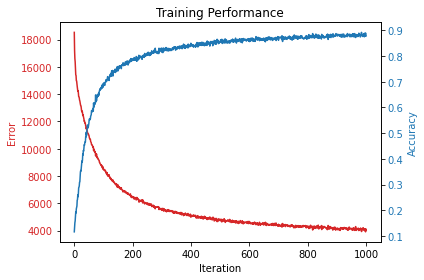

In [0]:
trained_w = train(x_train, y_train, max_iter=1000, alpha=0.01, hidden_layers=[200],batch_size=6000, lamb = 0.1, verbose=True)

Test accuracy: 0.8887
Test F1: 0.8869315019696501


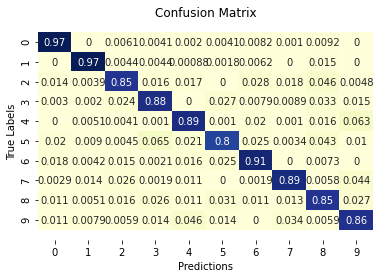

In [0]:
pred = predict(x_test, y_test,trained_w[0],trained_w[1],trained_w[2],trained_w[3])

acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='macro')
cm = confusion_matrix(y_test, pred)

print(f"Test accuracy: {acc}")
print(f"Test F1: {f1}")


conf_matrix = cm/np.sum(cm, axis=1, keepdims=True)
heat_map = sns.heatmap(conf_matrix,
            annot=True,
            cbar=False,
            cmap="YlGnBu")
bottom, top = heat_map.get_ylim()
heat_map.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Using Multiple Hidden Layers

********************
Iterations:1000
Learning Rate:0.01
Hidden Layer Sizes:[256, 256, 128]
Training Batch Size: 6000
Lambda:0.1
********************
Training Performance:
Final iter ACC:0.9082


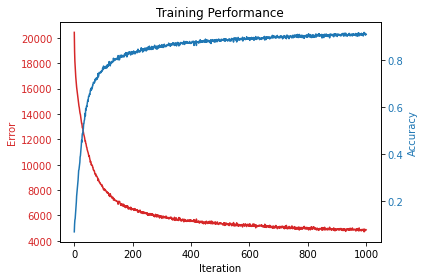

In [0]:
trained_w = train(x_train, y_train, max_iter=1000, alpha=0.01,
                  hidden_layers=[256, 256, 128],batch_size=6000, lamb = 0.1, verbose=True)

Test accuracy: 0.9102
Test F1: 0.9089386650049429


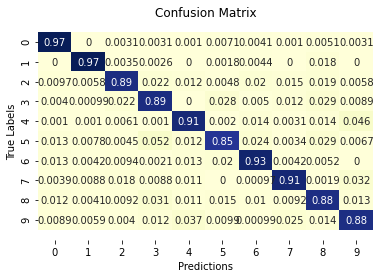

In [0]:
pred = predict(x_test, y_test,trained_w[0],trained_w[1],trained_w[2],trained_w[3])

acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='macro')
cm = confusion_matrix(y_test, pred)

print(f"Test accuracy: {acc}")
print(f"Test F1: {f1}")


conf_matrix = cm/np.sum(cm, axis=1, keepdims=True)
heat_map = sns.heatmap(conf_matrix,
            annot=True,
            cbar=False,
            cmap="YlGnBu")
bottom, top = heat_map.get_ylim()
heat_map.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()